In [15]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd

In [16]:
T = 0.05
s = ctl.TransferFunction.s

In [17]:
G = 1/(s**2 + 2*s + 3)
C = (17.446*s**2 + 97.59*s + 66.90)/(s**2 + 20*s)


G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([17.446, 97.59 , 66.9  ]), array([  1.   ,  22.   ,  60.446, 157.59 ,  66.9  ]))

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [18]:
G_z = ctl.c2d(G, T, method='zoh')
G_z

TransferFunction(array([0.0012086 , 0.00116897]), array([ 1.        , -1.89770468,  0.90483742]), 0.05)

In [19]:
C_z = ctl.c2d(C, T, method='tustin')
C_z

TransferFunction(array([ 13.28504167, -23.20558333,  10.03204167]), array([ 1.        , -1.33333333,  0.33333333]), 0.05)

In [20]:
G_z_feedback = ctl.feedback(G_z*C_z, 1)
G_z_feedback

TransferFunction(array([ 0.01605635, -0.01251649, -0.01500197,  0.0117272 ]), array([ 1.        , -3.21498166,  3.75592718, -1.85402008,  0.31333967]), 0.05)

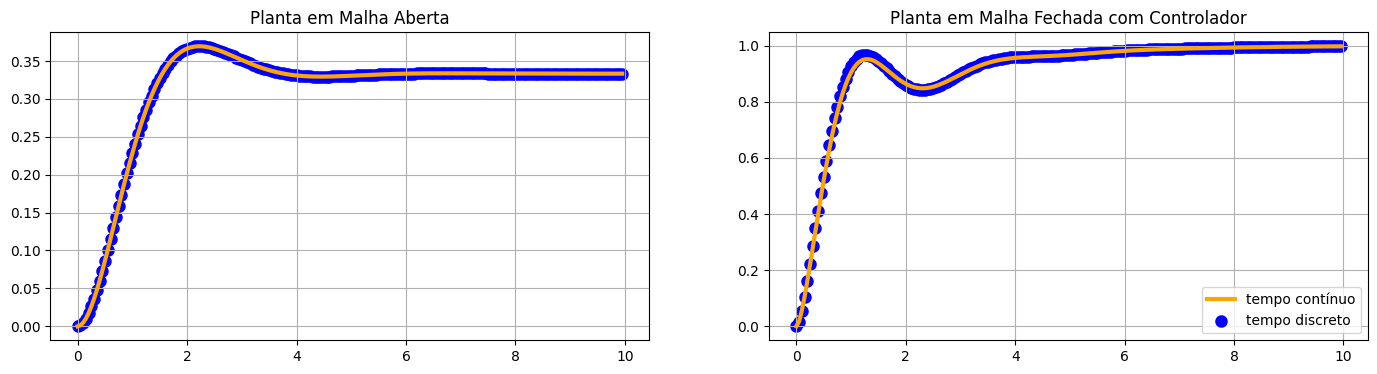

In [21]:
tData = np.arange(0, 10, T)
plt.figure(figsize=(17, 4))

plt.subplot(1, 2, 1)
time, continuous = ctl.step_response(G, T=tData)
time, digital    = ctl.step_response(G_z, T=tData)
plt.scatter(time, continuous, color='blue', linewidth=3, label='tempo discreto')
plt.plot(time, digital, color='orange', linewidth=3, label='tempo contínuo')
plt.title('Planta em Malha Aberta')
plt.grid()

plt.subplot(1, 2, 2)
time, continuous = ctl.step_response(G_feedback, T=tData)
time, digital    = ctl.step_response(G_z_feedback, T=tData)
plt.plot(time, continuous, color='orange', linewidth=3, label='tempo contínuo')
plt.scatter(time, digital, color='blue', linewidth=3, label='tempo discreto')
plt.title('Planta em Malha Fechada com Controlador')
plt.legend()
plt.grid()

# DIGITALIZANDO O SISTEMA
- Preparando as funções que permitem digitalizar a função de transferência em transformada $Z$
    - **getOutputString**: Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada
    - **resetSystem**: reinicia as variáveis globais do sistema
    - **compute**: aplica a função digitalizada a partir dos estados anteriores

In [22]:
def getOutputString(G_z):
    num, den = ctl.tfdata(G_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]
    out = ''

    for i in range(0, len(num)):
        out += f'{num[i]}*X_n{i} + '

    for i in range(1, len(den)):
        out += f'+ {-1*den[i]}*Y_n{i}'

    return out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')


def resetSystem():
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, X_n3
    Y_n1 = Y_n2 = Y_n3 = 0
    X_n1 = X_n2 = X_n3 = 0


def compute(X_n):
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, X_n3
    Y_n = eval(out)

    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n

    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n


resetSystem()
out = getOutputString(G_z)
out

'0.0012086039295136075*X_n + 0.0011689743235949734*X_n1 + 1.8977046832766336*Y_n1-0.9048374180359595*Y_n2'

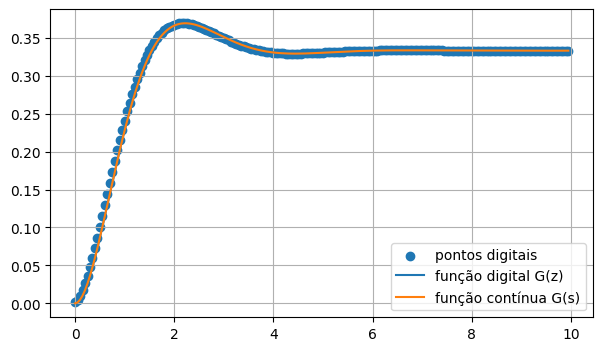

In [23]:
plt.figure(figsize=(7, 4))
time = np.arange(0, 10, T)

response = [compute(1) for i in time]
plt.scatter(time, response, label='pontos digitais')

time, response = ctl.step_response(G_z, T=time)
plt.plot(time, response, label='função digital G(z)')

time, response = ctl.step_response(G, T=time)
plt.plot(time, response, label='função contínua G(s)')
plt.grid()
plt.legend()

# DIGITALIZANDO O CONTROLADOR
- Comparando os dados contínuo e digital de forma gráfica através de um step

In [24]:
def computeController(input, setpoint):
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, X_n3

    X_n = setpoint - input
    Y_n = eval(out)

    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n

    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n


resetSystem()
out = getOutputString(C_z)
out

'13.285041666666668*X_n -23.205583333333337*X_n1 + 10.032041666666668*X_n2 + 1.3333333333333333*Y_n1-0.3333333333333333*Y_n2'

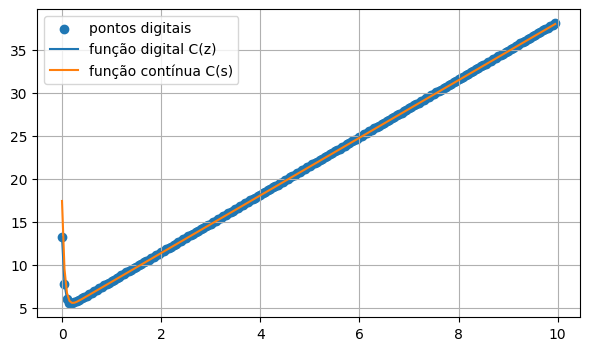

In [25]:
plt.figure(figsize=(7, 4))
time = np.arange(0, 10, T)

response = [computeController(input=1, setpoint=2) for i in time]
plt.scatter(time, response, label='pontos digitais')

time, response = ctl.step_response(C_z, T=time)
plt.plot(time, response, label='função digital C(z)')

time, response = ctl.step_response(C, T=time)
plt.plot(time, response, label='função contínua C(s)')
plt.grid()
plt.legend()

# TESTANDO A RESPOSTA
- Se o erro é positivo, o controlador atua aumentando a saída do sistema

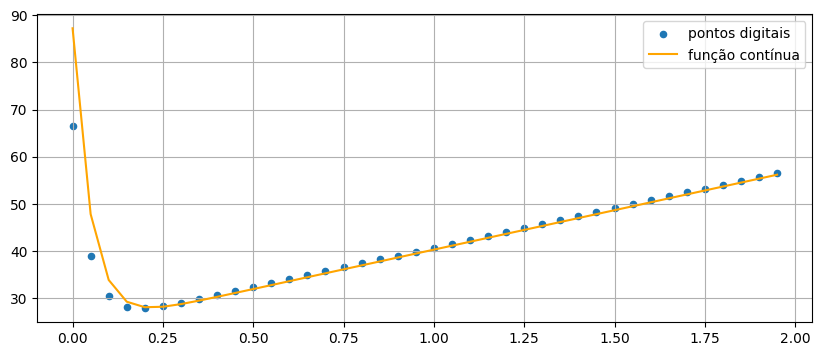

In [26]:
plt.figure(figsize=(10, 4))

inputValue = 5
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response, s=20, label='pontos digitais')

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.plot(time, response, color='orange', label='função contínua')
plt.grid()
plt.legend()

- Se o erro é negativo, o controlador atua diminuindo a saída do sistema

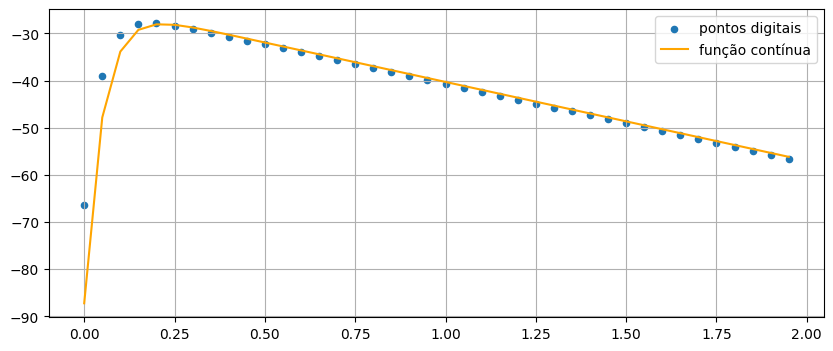

In [27]:
plt.figure(figsize=(10, 4))

inputValue = 15
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response, s=20, label='pontos digitais')

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.plot(time, response, color='orange', label='função contínua')
plt.grid()
plt.legend()

- Se o erro é zero, o não atua e mantém a saída fixa

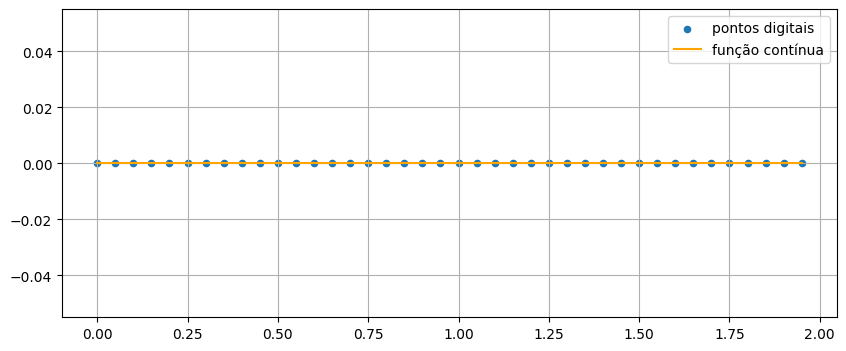

In [28]:
plt.figure(figsize=(10, 4))

inputValue = 10
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response, s=20, label='pontos digitais')

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.plot(time, response, color='orange', label='função contínua')
plt.grid()
plt.legend()